## Options and Libraries

In [88]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [89]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()

## Read data

In [203]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb

df["age"] = 2015 - df["year_birth"]

# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies = df_full_dummies.drop(columns=[
    #"response",
    "income_pred",
    "year_birth",
    "income_error", 
    "income_error_relative"
])

df_sel_dummies = df_full_dummies.drop(columns=[
    "id",
    
    #"marital_status_Divorced",
    "marital_status_Married",
    "marital_status_Single",
    "marital_status_Together",
    "marital_status_Widow",

    #"education_Basic",
    "education_2n Cycle",
    "education_Graduation",
    "education_Master",
    "education_PhD",

    #"mnt_wines",
    #"mnt_fruits",
    #"mnt_meat",
    #"mnt_fish",
    #"mnt_sweet",
    #"mnt_gold",
    
    #"num_deals",
    #"num_web",
    #"num_catalog",
    #"num_store",
    #"num_web_visits_month",
    
    "accepted_cmp1",
    "accepted_cmp2",
    "accepted_cmp3",
    "accepted_cmp4",
    "accepted_cmp5",

    "dt_customer",
    "recency",
    "complain",
    ],
    inplace=False)

In [204]:
# dropping some columns for "more targeted model"
regex_drop = r"error"
drop_cols = df_sel_dummies.filter(regex=regex_drop).columns

print(drop_cols)
df_sel_dummies.drop(columns=drop_cols, inplace=True)

Index([], dtype='object')


## Evaluate Clustering Algorithms

In [205]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

def evaluate_clustering(model_class, X, k_range, **model_kwargs):
    """
    Evaluates clustering models for a range of cluster numbers.
    """
    results = []
    
    for k in k_range:
        # Instantiate the clustering model with the current number of clusters
        model = model_class(k, **model_kwargs) 
        
        # Fit the model and predict labels
        model.fit(X)
        labels = model.labels_ if hasattr(model, "labels_") else model.predict(X)
        
        # Compute clustering statistics
        stats = {
            "k": k,
            "silhouette_score ↑": silhouette_score(X, labels),
            "calinski_harabasz_score ↑": calinski_harabasz_score(X, labels),
            "davies_bouldin_score ↓": davies_bouldin_score(X, labels),
        }
        results.append(stats)
    
    # Convert results into a DataFrame
    return pd.DataFrame(results).style.hide()


In [206]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_sel_dummies)
df_scaled = pd.DataFrame(df_scaled, columns = df_sel_dummies.columns)
df_scaled.head(6)

,education_years,income,kidhome,teenhome,age,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,response,mnt_total,num_total,accepted_total,accepted_any,marital_status_simple_Single
0,-0.350051,0.271601,-0.825218,-0.929894,0.985345,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,2.388846,1.679417,1.621229,-0.439037,-0.510442,1.346874
1,-0.350051,-0.327432,1.032559,0.906934,1.235733,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.418612,-0.961275,-1.258779,-0.439037,-0.510442,1.346874
2,-0.350051,0.956014,-0.825218,-0.929894,0.317643,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.418612,0.282673,0.661226,-0.439037,-0.510442,-0.742460
3,-0.350051,-1.327920,1.032559,-0.929894,-1.268149,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.418612,-0.918094,-0.847349,-0.439037,-0.510442,-0.742460
4,1.557769,0.279474,1.032559,-0.929894,-1.017761,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.418612,-0.305254,0.524083,-0.439037,-0.510442,-0.742460
5,0.285889,0.493813,-0.825218,0.906934,0.150717,0.642051,0.394768,-0.305541,-0.687068,0.361924,-0.575619,-0.168236,0.689386,0.457817,1.295237,0.281720,-0.418612,0.183025,1.072656,-0.439037,-0.510442,-0.742460


### K-Means

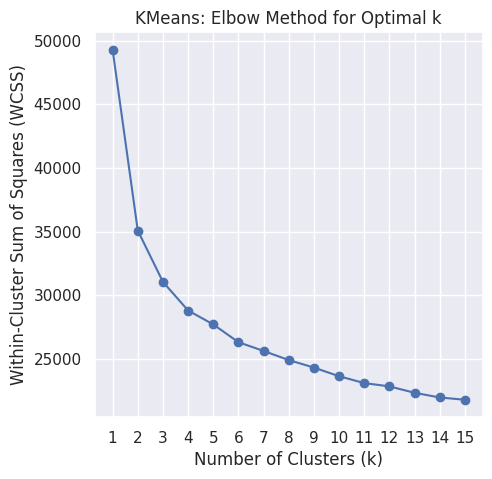

In [207]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

WCSS: measures the sum of squared distances between each data point and the centroid of its assigned cluster. 

In [208]:
# Evaluate KMeans
from sklearn.cluster import KMeans

kmeans_stats = evaluate_clustering(KMeans, df_scaled, range(2, 10), random_state=42, init="k-means++", max_iter=111)
print("KMeans Results:")
kmeans_stats

KMeans Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.285815,905.515824,1.514129
3,0.221534,656.653896,1.892511
4,0.216655,529.944837,1.971614
5,0.198911,434.876934,2.098109
6,0.128039,389.938823,2.176438
7,0.115711,343.515252,2.268173
8,0.115171,311.907394,2.266376
9,0.113843,286.202111,2.273757


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


### Gaussian Mixture

In [209]:
# Evaluate Gaussian Mixture
from sklearn.mixture import GaussianMixture

gmm_stats = evaluate_clustering(GaussianMixture, df_scaled, range(2, 9+1), random_state=42)
print("Gaussian Mixture Results:")
gmm_stats


Gaussian Mixture Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.269481,838.775136,1.570461
3,0.215288,492.611602,1.890512
4,0.158065,355.403454,1.993979
5,0.105227,284.826520,2.323464
6,0.075779,255.973825,2.574886
7,0.077578,263.279181,2.791526
8,0.074048,247.080548,2.451760
9,0.055042,210.754326,2.579556


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


#### Results of comparison 

- Not unambiguous when comparing across and within algorithms:
  - gaussian mixture has better silhouette, worse Calinski-Harabasz-Score and similar Davies-Bouldin-Score

## Clustering Algorithms

In [210]:
# for both models
n_clusters = 6

### a: Gaussian Mixture

In [211]:
df_scaled.columns

Index(['education_years', 'income', 'kidhome', 'teenhome', 'age', 'mnt_wines',
       'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold',
       'num_deals', 'num_web', 'num_catalog', 'num_store',
       'num_web_visits_month', 'response', 'mnt_total', 'num_total',
       'accepted_total', 'accepted_any', 'marital_status_simple_Single'],
      dtype='object')

In [212]:
# gaussian mixture
from sklearn.mixture import GaussianMixture
np.random.seed(42)

# fit clustering algo
gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of components
gmm.fit(df_scaled)
gmm_pred_proba_array = gmm.predict_proba(df_scaled)
df_pred_gmm = gmm.predict(df_scaled)

# merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_gausmx_pred_proba = pd.DataFrame(gmm_pred_proba_array, columns=column_names)
df_gausmx_pred_proba['pred_cluster'] = (df_pred_gmm+1) # add one to start at 1, not 0
df_gausmx_pred_proba.head()

,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5,prob_cluster_6,pred_cluster
0,0.000000e+00,0.000000,0.0,1.000000e+00,0.000000e+00,0.0,4
1,0.000000e+00,0.000000,1.0,2.090450e-10,8.721065e-214,0.0,3
2,6.223235e-249,0.999999,0.0,7.956384e-07,0.000000e+00,0.0,2
3,1.000000e+00,0.000000,0.0,1.174794e-10,4.864698e-193,0.0,1
4,1.319496e-51,0.000000,0.0,1.000000e+00,2.030432e-141,0.0,4


### b: KMEANS

In [213]:
np.random.seed(42)

# Fit KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++")
kmeans_model.fit(df_scaled)

# Predict probabilities for each cluster
kmeans_pred_proba_array = kmeans_model.transform(df_scaled)  # Distance to centroids
kmeans_pred_proba_array = 1 / (1 + kmeans_pred_proba_array)  # Convert distances to probabilities
kmeans_pred_proba_array /= kmeans_pred_proba_array.sum(axis=1, keepdims=True)  # Normalize
df_pred_kmeans = kmeans_model.labels_

# Merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_kmeans_pred_proba = pd.DataFrame(kmeans_pred_proba_array, columns=column_names)
df_kmeans_pred_proba['pred_cluster'] = (df_pred_kmeans + 1)  # Add one to start at 1, not 0
df_kmeans_pred_proba.head()

,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5,prob_cluster_6,pred_cluster
0,0.131479,0.174660,0.131988,0.217978,0.155711,0.188186,4
1,0.202542,0.139857,0.294379,0.115390,0.150982,0.096850,3
2,0.136573,0.217307,0.142092,0.212248,0.147911,0.143869,2
3,0.352797,0.119964,0.200295,0.103593,0.136852,0.086499,1
4,0.175704,0.178634,0.169741,0.153630,0.203767,0.118525,5


In [214]:
def reorder_clusters(df, cluster_col='pred_cluster', order_by='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[order_by].mean().sort_values(ascending=True)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = []  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc



## PICK model df

In [215]:
# pick winner (comment out the other)
#x_winner = df_kmeans_pred_proba
x_winner = df_gausmx_pred_proba

# make sure same number of rows for df and predictions
assert df_scaled.shape[0]==gmm_pred_proba_array.shape[0]

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_scaled.reset_index(drop=True),
    x_winner.reset_index(drop=True)], axis=1, ignore_index=False)

# reorder the cluster by: 
order_by = "income" # mnt_total is also a good one
order_by = "mnt_total" # mnt_total is also a good one
df_predicted = reorder_clusters(df_predicted, order_by=order_by)

df_predicted.groupby("pred_cluster").mean()


,education_years,income,kidhome,teenhome,age,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,response,mnt_total,num_total,accepted_total,accepted_any,marital_status_simple_Single,_prob_1,_prob_2,_prob_3,_prob_4,_prob_5,_prob_6
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.357263,-1.087964,0.764426,-0.929894,-0.704389,-0.852460,-0.547583,-0.665230,-0.563017,-0.538181,-0.598627,-0.341142,-0.809825,-0.793782,-0.899689,0.624215,-0.071298,-0.901736,-0.910407,-0.308315,-0.291495,-0.018732,9.968352e-01,0.000000e+00,3.857734e-07,6.433706e-04,2.520907e-03,1.718497e-07
2,0.106132,-0.613054,0.691811,0.906934,0.343646,-0.743590,-0.611722,-0.662064,-0.631174,-0.603316,-0.623601,0.024257,-0.741406,-0.735510,-0.788881,0.349037,-0.249318,-0.856749,-0.806344,-0.335309,-0.336707,-0.002269,0.000000e+00,9.985843e-01,1.277902e-07,1.250963e-04,1.290465e-03,3.796410e-12
3,0.440996,-0.114210,0.624754,0.414126,-0.042672,0.127751,-0.402609,-0.409732,-0.472714,-0.456575,0.295598,1.952867,0.373324,0.007142,-0.228106,1.256886,0.608507,-0.157321,0.978997,1.143275,1.718155,0.378646,6.258741e-12,3.082214e-03,9.968668e-01,6.401950e-22,6.823907e-32,5.101530e-05
4,0.136188,0.195959,0.585065,0.048854,-0.138052,0.067388,0.163296,0.248781,0.119547,0.145711,0.243656,0.974751,0.580347,0.166840,0.197056,0.198983,0.513792,0.183625,0.700267,-0.439037,-0.510442,0.111575,1.955831e-03,1.754995e-03,5.210467e-78,9.962892e-01,6.369334e-36,0.000000e+00
5,0.049479,0.571683,-0.825218,0.186098,0.298504,0.446584,0.425029,0.373309,0.446945,0.403281,0.415501,-0.113779,0.454519,0.499477,0.688261,-0.507080,-0.418612,0.521752,0.481287,-0.161928,-0.046311,-0.055894,5.716922e-04,1.853995e-03,5.506546e-10,1.898093e-06,9.975715e-01,9.469715e-07
6,0.172328,1.219408,-0.683041,-0.498802,-0.041332,1.570818,0.618534,1.117102,0.677449,0.707942,0.551694,-0.485165,0.658165,1.067105,0.629665,-0.605736,1.644010,1.495219,0.629040,2.517341,1.959085,0.057030,4.052038e-24,2.110335e-12,4.994967e-04,0.000000e+00,1.171669e-14,9.995005e-01


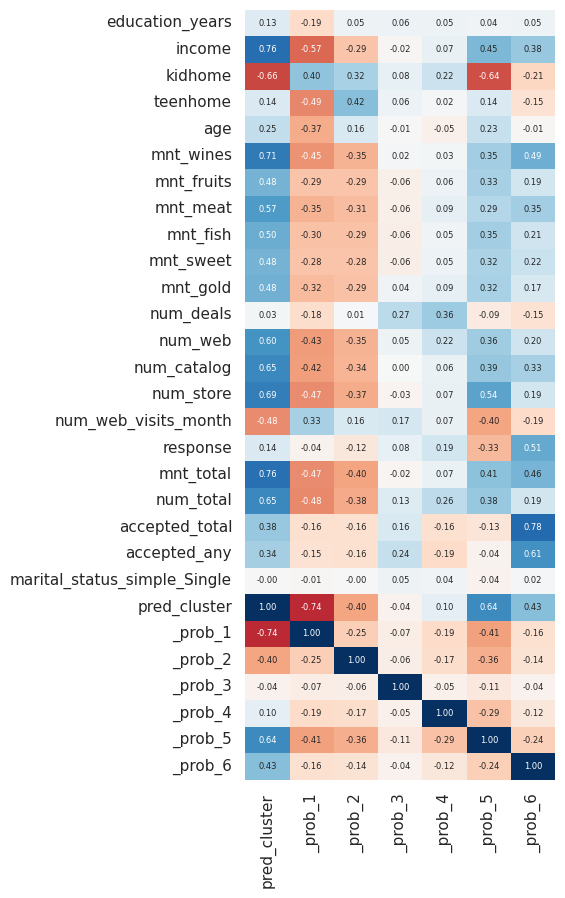

In [216]:
# get correlations 
df_predicted_encoded = pd.get_dummies(df_predicted, drop_first=False)
df_corr = df_predicted_encoded.corr()
df_corr_toplot = df_corr.filter(regex="prob|pred|pca", axis=1)
#df_corr_toplot.drop(columns="pred_cluster", axis=1, inplace=True)
# heatmap
from matplotlib import pyplot as plt
import seaborn as sns

def heatmap(df, file_name=None, figsize=(5,10)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap='RdBu',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 6},
        vmin=-1, vmax=1,
        cbar=False
    )

    if file_name is not None:
        # save the plot as JPG file
        #print(f"saving {file_name}")
        plt.savefig(
            file_name,
            dpi=300,
            bbox_inches='tight'
        )
        plt.show()


heatmap(df_corr_toplot,
    file_name=f"output/figures/fig_corrplot_first_look_{n_clusters}_clst_income_pred.png",
    figsize=(4,10)
)

## PCA

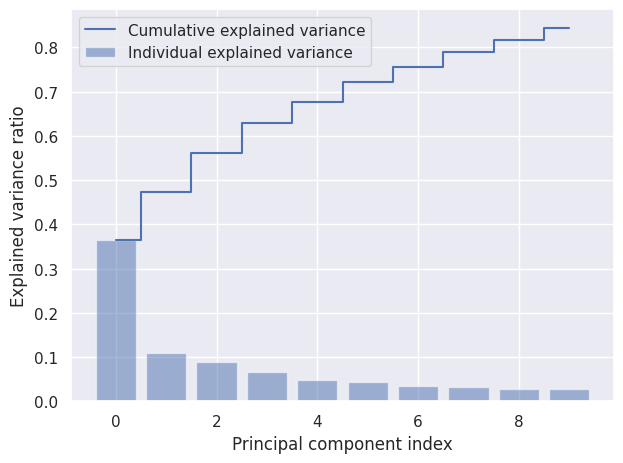

In [217]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit_transform(df_scaled)

exp_var_pca_sng = pca.explained_variance_ratio_
exp_var_pca_sum = np.cumsum(pca.explained_variance_ratio_)

plt.bar(range(0,len(exp_var_pca_sng)), exp_var_pca_sng, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca_sum)), exp_var_pca_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [218]:
df_pca =  df_scaled.copy()
df_pca["pca_1"]  = df_scaled.dot(pca.components_[0])
df_pca["pca_2"] = df_scaled.dot(pca.components_[1])
df_pca["pca_3"]  = df_scaled.dot(pca.components_[2])
df_pca["pca_4"] = df_scaled.dot(pca.components_[3])

# merge predictions onto pca dataset
df_pca = pd.merge(
    df_pca.reset_index(),
    x_winner.reset_index(),
    left_index=False,
    right_index=False,
    how="inner"
).drop(columns=["index"])
df_pca

,education_years,income,kidhome,teenhome,age,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,response,mnt_total,num_total,accepted_total,accepted_any,marital_status_simple_Single,pca_1,pca_2,pca_3,pca_4,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5,prob_cluster_6,pred_cluster
0,-0.350051,0.271601,-0.825218,-0.929894,0.985345,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,2.388846,1.679417,1.621229,-0.439037,-0.510442,1.346874,4.367683,0.091957,-0.351749,-1.890608,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4
1,-0.350051,-0.327432,1.032559,0.906934,1.235733,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.418612,-0.961275,-1.258779,-0.439037,-0.510442,1.346874,-2.860889,-0.250700,-0.276011,1.276190,0.000000e+00,0.000000,1.000000e+00,2.090450e-10,8.721065e-214,0.000000e+00,3
2,-0.350051,0.956014,-0.825218,-0.929894,0.317643,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.418612,0.282673,0.661226,-0.439037,-0.510442,-0.742460,1.741175,-0.097651,-1.406432,-0.075781,6.223235e-249,0.999999,0.000000e+00,7.956384e-07,0.000000e+00,0.000000e+00,2
3,-0.350051,-1.327920,1.032559,-0.929894,-1.268149,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.418612,-0.918094,-0.847349,-0.439037,-0.510442,-0.742460,-3.008954,-1.055451,-0.022529,-0.910643,1.000000e+00,0.000000,0.000000e+00,1.174794e-10,4.864698e-193,0.000000e+00,1
4,1.557769,0.279474,1.032559,-0.929894,-1.017761,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.418612,-0.305254,0.524083,-0.439037,-0.510442,-0.742460,-0.332747,0.593997,-0.468382,-0.762503,1.319496e-51,0.000000,0.000000e+00,1.000000e+00,2.030432e-141,0.000000e+00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.350051,0.428292,-0.825218,0.906934,0.150717,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,-0.168236,1.769263,0.115638,-0.550785,-0.130463,-0.418612,1.221032,0.386940,-0.439037,-0.510442,-0.742460,2.673423,0.968069,-1.481780,-0.943143,0.000000e+00,0.999986,0.000000e+00,1.380247e-05,1.224592e-245,0.000000e+00,2
2236,1.557769,0.570051,2.890335,0.906934,1.903435,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,2.420015,1.409304,-0.226541,-0.243114,0.693904,-0.418612,-0.268717,1.209799,1.035390,1.959085,-0.742460,-0.436908,3.687795,2.233879,0.596469,0.000000e+00,0.000000,4.788064e-13,0.000000e+00,1.000000e+00,3.040435e-21,5
2237,-0.350051,0.212835,-0.825218,-0.929894,-1.017761,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,-0.685887,-0.750450,0.115638,2.218248,0.281720,-0.418612,1.054951,0.661226,1.035390,1.959085,1.346874,2.133565,-0.684198,1.598531,-0.228708,0.000000e+00,0.999999,0.000000e+00,0.000000e+00,2.980821e-54,6.915382e-07,2
2238,0.285889,0.835741,-0.825218,0.906934,1.068807,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,-0.168236,0.689386,0.799996,1.295237,-0.954831,-0.418612,0.393948,0.798370,-0.439037,-0.510442,-0.742460,1.979235,0.996644,-1.538998,1.191196,0.000000e+00,1.000000,7.661324e-151,8.418768e-08,9.241073e-318,0.000000e+00,2


In [219]:
# plot opts
sns.set_theme()
p_pal = sns.color_palette("viridis", as_cmap=True)
p_alpha = 1

<Axes: xlabel='pca_1', ylabel='pca_4'>

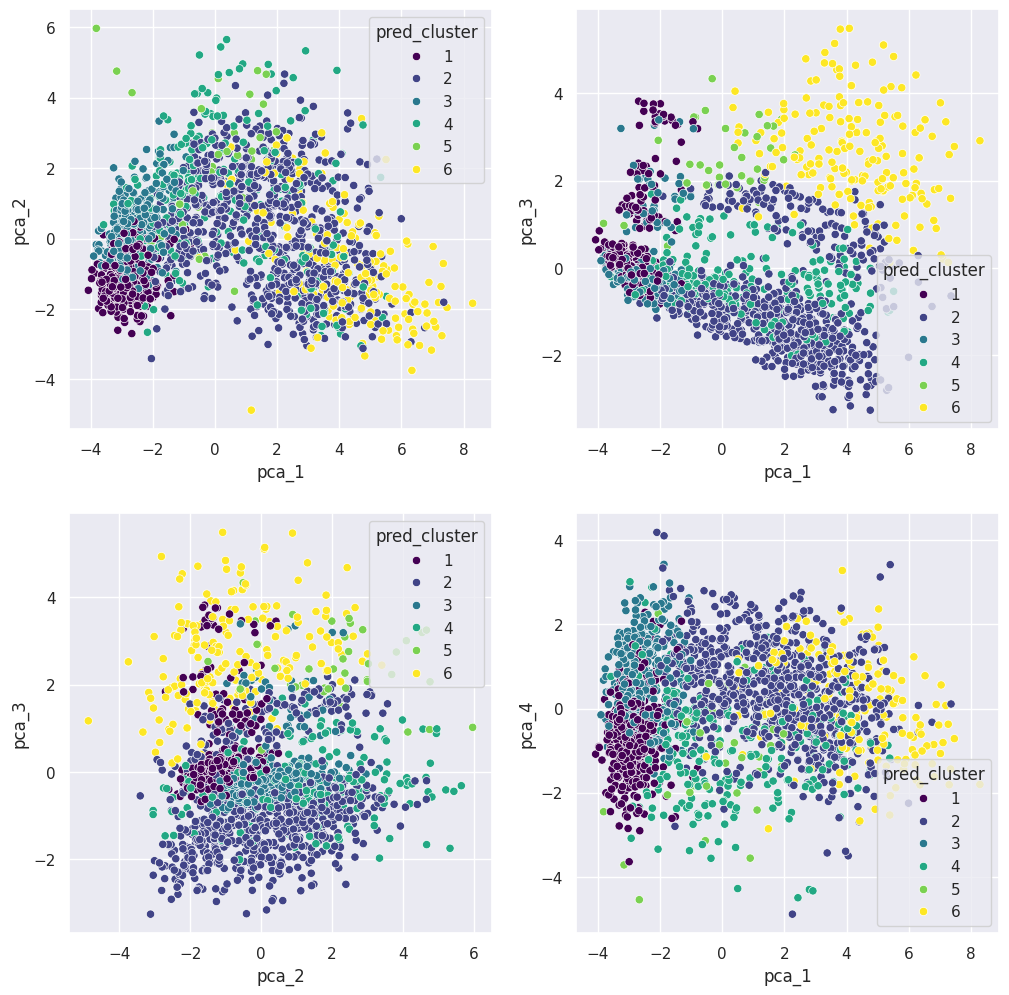

In [220]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_2", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_3", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,3)
sns.scatterplot(data=df_pca, x="pca_2", y="pca_3", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,4)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_4", hue="pred_cluster", alpha=p_alpha, palette=p_pal)

<Axes: xlabel='income', ylabel='pca_2'>

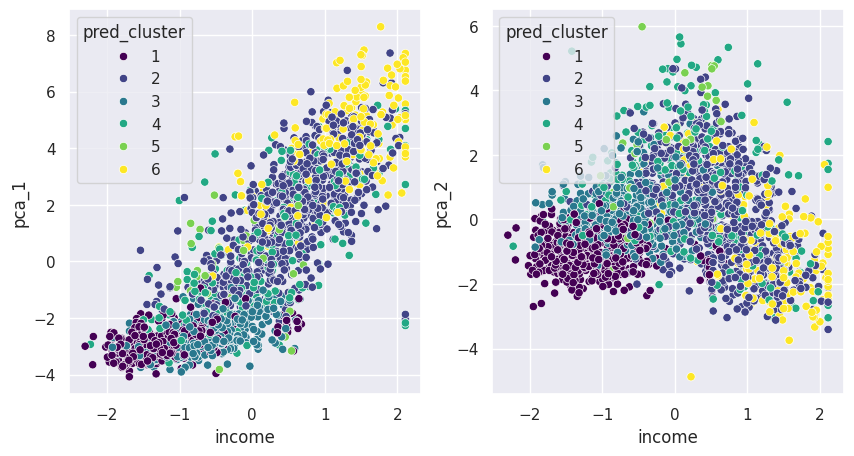

In [222]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_pca, x="income", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_pca, x="income", y="pca_2", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

<Axes: xlabel='mnt_total', ylabel='pca_2'>

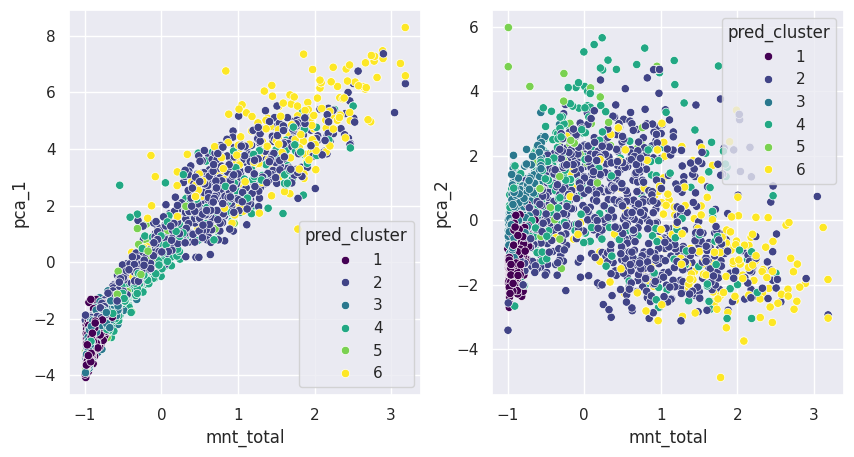

In [223]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_pca, x="mnt_total", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_pca, x="mnt_total", y="pca_2", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

In [226]:
dftoplot = df_pca.filter(regex="_prob|pca|pred|pro", axis=1)
dftoplot.columns

Index(['pca_1', 'pca_2', 'pca_3', 'pca_4', 'prob_cluster_1', 'prob_cluster_2',
       'prob_cluster_3', 'prob_cluster_4', 'prob_cluster_5', 'prob_cluster_6',
       'pred_cluster'],
      dtype='object')

### Correlation matrix with PCA

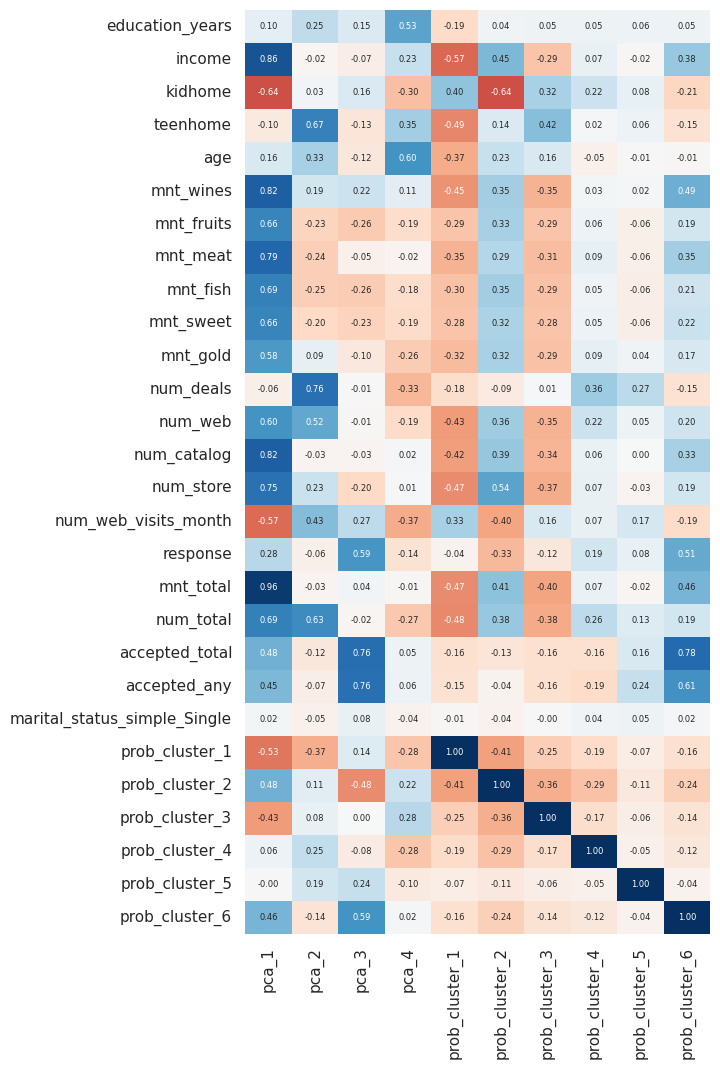

In [227]:
dftoplot = df_pca.corr().filter(regex="_prob|pca|pro", axis=1)
dftoplot = dftoplot.drop(index=df_pca.filter(regex="_prob|pca|pred", axis=1).columns, axis=0)
heatmap(dftoplot, figsize=(6,12))

## Summary Stats

In [124]:
def summary_stats_by_group(df, group_var, target_var, sorted=False):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p05=lambda x: x.quantile(0.05),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    ).reset_index()

    # Sort by mean value (descending order)
    if sorted: summary = summary.sort_values(by="mean", ascending=True)

    return summary.style.hide()

In [125]:
print("income")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income")

income


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-1.035033,-2.300371,0.679196,-1.836163,-1.690164,-1.459800,-1.098648,-0.728176,-0.370148,0.311596
2,560,-0.366775,-1.923601,1.248725,-1.346357,-1.119945,-0.793114,-0.358948,0.071445,0.413155,0.626048
3,21,0.153401,-0.762714,0.878710,-0.547003,-0.457509,-0.110705,0.219235,0.510676,0.570051,0.570051
4,786,0.498896,-2.227231,2.112584,-0.991122,-0.620930,0.060258,0.622772,1.027948,1.411105,1.580621
5,167,0.693662,-1.023273,2.112584,-0.500666,-0.195740,0.203871,0.743707,1.200626,1.478932,1.639783
6,175,1.393146,-0.344142,2.112584,0.209935,0.644623,1.167052,1.484854,1.762530,2.039089,2.112584


In [126]:
print("num_web")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web")

num_web


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.805359,-1.470368,1.049345,-1.110409,-1.110409,-1.110409,-0.750450,-0.390491,-0.390491,-0.210512
2,560,-0.280575,-1.470368,2.489181,-1.110409,-1.110409,-1.110409,-0.390491,0.329427,1.049345,1.409304
3,21,0.312286,-1.470368,2.129222,-1.470368,-1.470368,-0.390491,0.329427,1.409304,1.409304,2.129222
4,786,0.478265,-1.470368,8.248526,-0.750450,-0.390491,-0.030532,0.329427,1.049345,1.769263,2.129222
5,167,0.717407,-1.470368,2.489181,-0.750450,-0.390491,-0.030532,0.689386,1.049345,2.129222,2.489181
6,175,0.471354,-1.110409,2.489181,-0.750450,-0.390491,-0.030532,0.329427,1.049345,1.409304,2.129222


In [127]:
print("num_web_visits_month")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web_visits_month")

num_web_visits_month


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,0.641119,-1.367014,6.052291,-0.542647,-0.130463,0.281720,0.693904,1.106087,1.106087,1.518271
2,560,0.221365,-1.779198,1.518271,-0.954831,-0.583865,-0.130463,0.281720,0.693904,1.106087,1.106087
3,21,1.753804,0.281720,6.052291,0.281720,0.281720,0.693904,1.106087,1.518271,5.640107,5.640107
4,786,-0.389520,-2.191381,1.930455,-1.779198,-1.779198,-1.367014,-0.542647,0.281720,1.106087,1.106087
5,167,-0.239063,-2.191381,1.518271,-1.779198,-1.367014,-0.954831,-0.130463,0.693904,1.106087,1.106087
6,175,-0.886526,-1.779198,1.518271,-1.779198,-1.779198,-1.367014,-1.367014,-0.542647,0.281720,0.693904


In [128]:
print("age")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="age")

age


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.625596,-2.269702,1.986898,-1.685463,-1.518538,-1.184687,-0.683910,-0.266596,0.234180,1.068807
2,560,0.373235,-1.017761,1.903435,-0.767373,-0.600447,-0.266596,0.317643,0.985345,1.402658,1.569584
3,21,0.118922,-1.852388,1.903435,-1.768926,-1.101224,-0.767373,-0.016208,1.152270,1.653047,1.903435
4,786,0.101553,-2.186239,6.326960,-1.602000,-1.268149,-0.600447,-0.016208,0.901882,1.402658,1.736509
5,167,0.253172,-1.935851,2.153823,-1.493499,-1.101224,-0.516985,0.401106,0.985345,1.653047,1.736509
6,175,-0.008100,-2.186239,5.826184,-1.793965,-1.518538,-1.059492,-0.099671,0.985345,1.619662,1.819972


In [129]:
print("income")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income")

income


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-1.035033,-2.300371,0.679196,-1.836163,-1.690164,-1.459800,-1.098648,-0.728176,-0.370148,0.311596
2,560,-0.366775,-1.923601,1.248725,-1.346357,-1.119945,-0.793114,-0.358948,0.071445,0.413155,0.626048
3,21,0.153401,-0.762714,0.878710,-0.547003,-0.457509,-0.110705,0.219235,0.510676,0.570051,0.570051
4,786,0.498896,-2.227231,2.112584,-0.991122,-0.620930,0.060258,0.622772,1.027948,1.411105,1.580621
5,167,0.693662,-1.023273,2.112584,-0.500666,-0.195740,0.203871,0.743707,1.200626,1.478932,1.639783
6,175,1.393146,-0.344142,2.112584,0.209935,0.644623,1.167052,1.484854,1.762530,2.039089,2.112584


In [130]:
print("mnt_wines")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_wines")

mnt_wines


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.841782,-0.903167,-0.406914,-0.900195,-0.897224,-0.891280,-0.870479,-0.828877,-0.751617,-0.675842
2,560,-0.469593,-0.897224,1.530550,-0.882366,-0.873451,-0.834821,-0.701100,-0.277651,0.362426,0.663892
3,21,0.370647,-0.900195,2.362591,-0.888309,-0.704071,-0.389085,0.303291,0.546960,1.961428,2.362591
4,786,0.309427,-0.900195,3.245147,-0.797676,-0.655041,-0.343768,0.188886,0.840403,1.453290,1.841823
5,167,0.991984,-0.808076,3.054967,-0.364421,-0.166217,0.307749,0.897606,1.763819,2.089800,2.402112
6,175,1.676022,-0.790247,3.533390,-0.380170,0.363911,1.046184,1.774219,2.386363,2.915303,3.288235


In [131]:
print("mnt_fruits")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_fruits")

mnt_fruits


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.556216,-0.661449,-0.057897,-0.661449,-0.661449,-0.636301,-0.586005,-0.510561,-0.409969,-0.309377
2,560,-0.550394,-0.661449,0.168436,-0.661449,-0.661449,-0.661449,-0.611153,-0.510561,-0.334525,-0.208785
3,21,-0.419549,-0.661449,0.671396,-0.661449,-0.661449,-0.661449,-0.636301,-0.384821,0.143288,0.193584
4,786,0.542425,-0.661449,4.343008,-0.661449,-0.611153,-0.359673,0.193584,1.124061,2.293444,3.022736
5,167,0.389497,-0.661449,4.116675,-0.661449,-0.661449,-0.435117,-0.032749,0.797136,2.084715,3.140932
6,175,0.691371,-0.661449,3.990935,-0.661449,-0.515591,-0.145915,0.118140,1.337819,2.869333,3.186199


In [132]:
print("mnt_total")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_total")

mnt_total


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.895456,-0.997813,-0.443102,-0.979544,-0.972901,-0.951311,-0.916434,-0.873252,-0.783568,-0.724610
2,560,-0.644182,-0.992831,0.609853,-0.973067,-0.961608,-0.928059,-0.803498,-0.470090,-0.097653,0.131788
3,21,-0.033751,-0.992831,0.950320,-0.991170,-0.710493,-0.268717,-0.187337,0.173060,0.922086,0.950320
4,786,0.501491,-0.996153,3.046266,-0.688072,-0.547733,-0.148308,0.511865,1.004712,1.589733,1.808130
5,167,0.963418,-0.575967,2.900114,-0.319703,-0.191655,0.452076,0.827420,1.532435,2.047453,2.379948
6,175,1.610716,-0.929720,3.187435,0.293302,0.757666,1.193629,1.676095,2.149427,2.494544,2.753298


In [133]:
print("accepted_total")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="accepted_total")

accepted_total


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,531,-0.244668,-0.439037,1.035390,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,1.035390,1.035390
2,560,-0.349518,-0.439037,1.035390,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,1.035390
3,21,0.824758,-0.439037,2.509818,-0.439037,-0.439037,1.035390,1.035390,1.035390,1.035390,1.035390
4,786,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037,-0.439037
5,167,1.229626,1.035390,2.509818,1.035390,1.035390,1.035390,1.035390,1.035390,2.509818,2.509818
6,175,2.560370,1.035390,5.458673,1.035390,1.035390,1.035390,2.509818,3.984246,3.984246,5.458673


In [149]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_strip_matrix_auto(df, group_var, target_vars, figsize=(9, 7), jitter=True, cut=0):
    """
    Creates a matrix of violin and strip plots for multiple target variables,
    with rows and columns determined automatically.
    """
    num_vars = len(target_vars)
    cols = math.ceil(math.sqrt(num_vars))  # Number of columns
    rows = math.ceil(num_vars / cols)     # Number of rows

    # Create the grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, target_var in enumerate(target_vars):
        if i < len(axes):
            ax = axes[i]  # Select subplot
            sns.violinplot(
                x=target_var, y=group_var, data=df, cut=cut, ax=ax, hue=group_var
            )
            if jitter:
                sns.stripplot(
                    x=target_var, y=group_var, data=df,
                    color="black", size=3, alpha=0.1, jitter=0.2, ax=ax
                )
            ax.set_title(f"Distribution of {target_var}")
            ax.set(xlabel=None, ylabel=None)
        else:
            axes[i].axis("off")  # Hide unused subplots

    # Turn off any remaining unused subplots
    for i in range(num_vars, len(axes)):
        axes[i].axis("off")

    plt.show()


In [150]:
df_predicted_encoded['pred_cluster_cat'] = pd.Categorical(df_predicted_encoded["pred_cluster"])

In [152]:
df_predicted_encoded.columns

Index(['education_years', 'income', 'kidhome', 'teenhome', 'age', 'mnt_wines',
       'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold',
       'num_deals', 'num_web', 'num_catalog', 'num_store',
       'num_web_visits_month', 'accepted_cmp1', 'accepted_cmp2',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'response',
       'mnt_total', 'num_total', 'accepted_total', 'accepted_any',
       'marital_status_simple_Single', 'pred_cluster', '_prob_1', '_prob_2',
       '_prob_3', '_prob_4', '_prob_5', '_prob_6', 'pred_cluster_cat'],
      dtype='object')

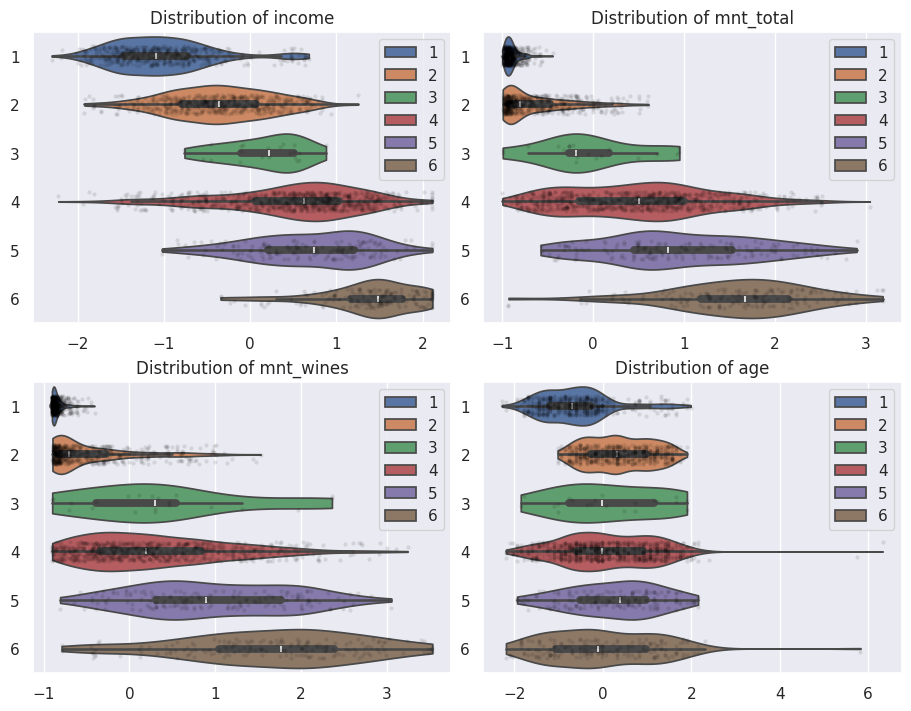

In [155]:
target_vars = ["income", "mnt_total", "mnt_wines", "age"]
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

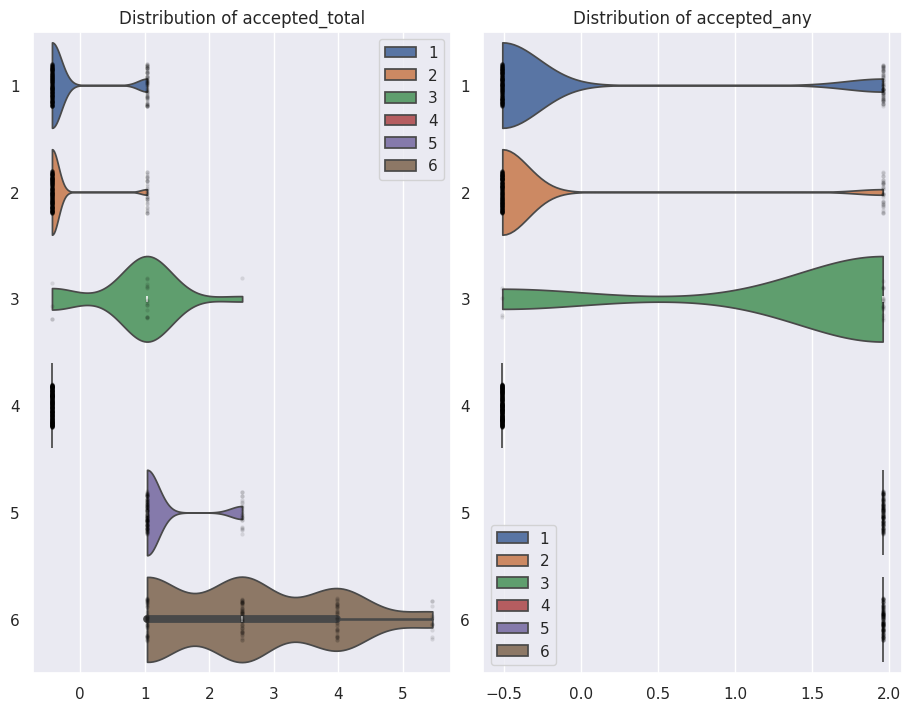

In [156]:
target_vars = ['accepted_cmp1', 'accepted_cmp2', 'accepted_cmp2', 'accepted_cmp4', 'accepted_cmp5', 'accepted_total', 'accepted_any']
target_vars = ['accepted_total', 'accepted_any']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

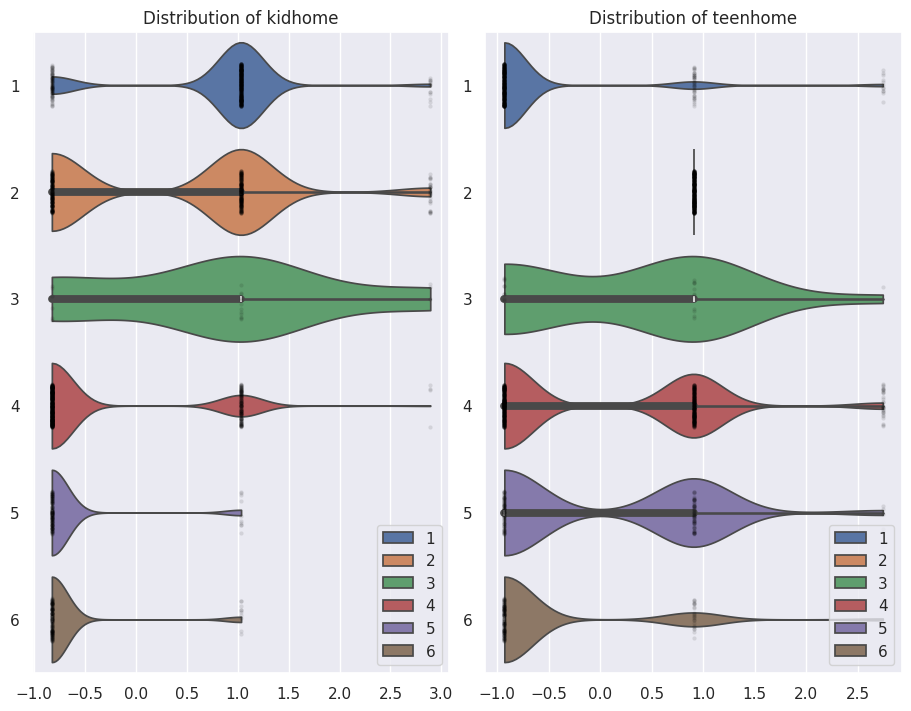

In [157]:
target_vars = ['kidhome', 'teenhome']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

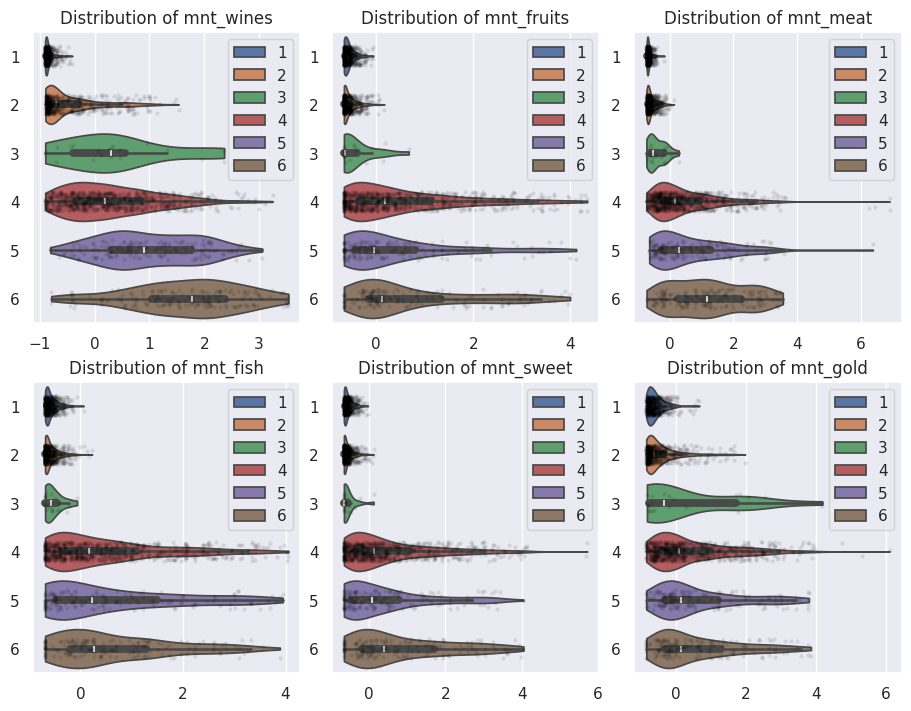

In [158]:
target_vars = ['mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

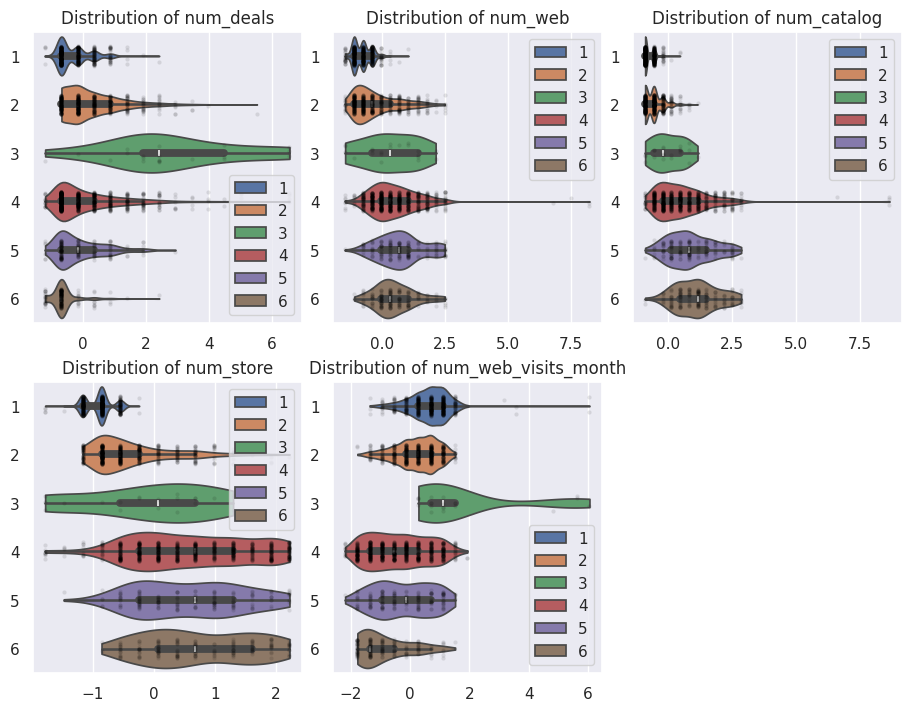

In [159]:
target_vars = ['num_deals', 'num_web', 'num_catalog', 'num_store', 'num_web_visits_month']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)